In [153]:
import os
import pickle
import numpy as np
import pandas as pd
import math
from itertools import chain
import itertools
import random
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch.autograd.function import Function
import torch.nn.utils.prune as prune
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift



from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import nn, einsum
import logging
from functools import partial
from collections import OrderedDict
import seaborn as sns
import matplotlib as mp
import time
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import importlib
import sys

sys.path.append('../src')
from utils import data_handler
from utils import benchmark
from utils import visualisation
from utils.models.VQ_VAE import Model
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

import json
from tqdm import tqdm


# Now I'm plugging my own dataset 

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  1 ...
0.0
4194.0


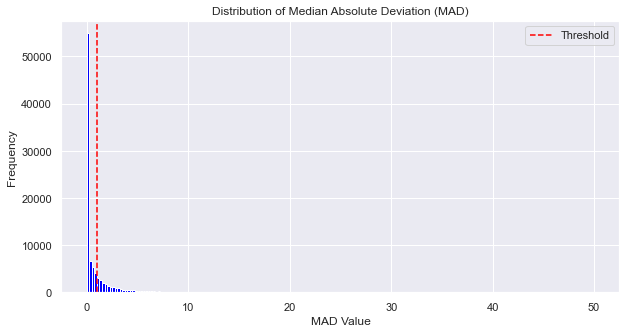

removing 71320 genes under the MAD threshold from the dataset
number of genes selected :  23989
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


In [192]:
as_time_series = True
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 1, 
    subsample=None, 
    retain_phases = None,
    normalization = False,
    minimum_time_point = "BL",
    as_time_series = False,
    transpose = False,
    MT_removal = False,
    log1p = True,
    min_max = True)

data = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)


In [193]:
# adding my own labels :

metadata_path = "../../METADATA_200123.xlsx"

meta_data = pd.read_excel(metadata_path, header = 1, usecols = range(1,10) )
patient_ids = [name.split(".")[1] for name in filenames]
clinical_info = meta_data.loc[meta_data['Patient Number'].astype(str).isin(patient_ids), 'Disease Status'].tolist()
clinical_info[0:5]


['Prodromal', 'Prodromal', 'Prodromal', 'Prodromal', 'Prodromal']

back to the regular notebook

In [194]:
dat = pd.DataFrame(data)
feature_num = dat.shape[1]
data_num = dat.shape[0]
dat = dat.values.reshape(-1,1,feature_num)
print(dat.shape)

(4445, 1, 23989)


In [195]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data1 ,transform = None):
        self.transform = transform
        self.data1 = data1
        self.datanum = len(data1)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        
        out_data1 = torch.tensor(self.data1[idx]).float() 
        if self.transform:
            out_data1 = self.transform(out_data1)

        return out_data1

In [197]:
train_data, test_data = train_test_split(dat, test_size = 0.2,random_state = 66)
print('train data:',len(train_data))
print('test data:',len(test_data))
train_data_set = Mydatasets(data1 = train_data)
test_data_set = Mydatasets(data1 = test_data)
train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = 256, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size = 32, shuffle=False)

train data: 3556
test data: 889


In [198]:
#DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# for m1 mac
DEVICE = torch.device("mps")

out_dim = 512   
VQ_VAE = Model(
            dropout = 0.0,
            input_size = feature_num, 
            encoder_dim = out_dim,
            num_embeddings = 64,  
            embedding_dim = 64,   
            commitment_cost = 1
           ).to(DEVICE)

Classifier_loss = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(VQ_VAE.parameters(), lr=1e-3, amsgrad=False)
data_variance = np.var(dat)

print(DEVICE)

mps


Added feature to monitor training


  1%|          | 1/100 [00:25<42:19, 25.65s/it]

Epoch 1/100, Training Loss: 19.718069996152604, Validation Loss: 5.713412335940769, Learning Rate: 0.001


  2%|▏         | 2/100 [00:52<42:56, 26.29s/it]

Epoch 2/100, Training Loss: 2.368663498333522, Validation Loss: 0.6487699512924466, Learning Rate: 0.001


  3%|▎         | 3/100 [01:17<41:32, 25.69s/it]

Epoch 3/100, Training Loss: 0.5707175178187234, Validation Loss: 0.5344698620694024, Learning Rate: 0.001


  4%|▍         | 4/100 [01:40<39:34, 24.73s/it]

Epoch 4/100, Training Loss: 0.5363701922552926, Validation Loss: 0.5288760896239962, Learning Rate: 0.001


  5%|▌         | 5/100 [01:59<36:01, 22.75s/it]

Epoch 5/100, Training Loss: 0.5295828240258353, Validation Loss: 0.5255688460809844, Learning Rate: 0.001


  6%|▌         | 6/100 [02:17<32:55, 21.02s/it]

Epoch 6/100, Training Loss: 0.527820770229612, Validation Loss: 0.5245667546987534, Learning Rate: 0.001


  7%|▋         | 7/100 [02:46<36:35, 23.61s/it]

Epoch 7/100, Training Loss: 0.5269765385559627, Validation Loss: 0.5253259677972112, Learning Rate: 0.001


  8%|▊         | 8/100 [03:09<35:42, 23.29s/it]

Epoch 8/100, Training Loss: 0.5271551587751934, Validation Loss: 0.5246966928243637, Learning Rate: 0.001


  9%|▉         | 9/100 [03:27<33:05, 21.82s/it]

Epoch 9/100, Training Loss: 0.5278350199971881, Validation Loss: 0.525033488869667, Learning Rate: 0.001


 10%|█         | 10/100 [03:49<32:44, 21.83s/it]

Epoch 10/100, Training Loss: 0.5270834267139435, Validation Loss: 0.5255806158695903, Learning Rate: 0.001


 11%|█         | 11/100 [04:05<29:41, 20.01s/it]

Epoch 11/100, Training Loss: 0.5270187599318368, Validation Loss: 0.5249163050736699, Learning Rate: 0.001


 12%|█▏        | 12/100 [04:22<28:07, 19.18s/it]

Epoch 12/100, Training Loss: 0.5271683463028499, Validation Loss: 0.5282214124287877, Learning Rate: 0.001


 13%|█▎        | 13/100 [04:46<29:43, 20.50s/it]

Epoch 13/100, Training Loss: 0.5287491040570396, Validation Loss: 0.5260229472603116, Learning Rate: 0.001


 14%|█▍        | 14/100 [05:00<26:52, 18.75s/it]

Epoch 14/100, Training Loss: 0.5284078802381244, Validation Loss: 0.5261736639908382, Learning Rate: 0.001


 15%|█▌        | 15/100 [05:27<29:41, 20.96s/it]

Epoch 15/100, Training Loss: 0.528144644839423, Validation Loss: 0.5262255370616913, Learning Rate: 0.001


 16%|█▌        | 16/100 [05:55<32:38, 23.31s/it]

Epoch 16/100, Training Loss: 0.5281099804810115, Validation Loss: 0.5293933674693108, Learning Rate: 0.001


 17%|█▋        | 17/100 [06:19<32:28, 23.48s/it]

Epoch 00017: reducing learning rate of group 0 to 1.0000e-04.
Epoch 17/100, Training Loss: 0.5305787367480141, Validation Loss: 0.5297578583870616, Learning Rate: 0.0001


 18%|█▊        | 18/100 [06:31<27:16, 19.96s/it]

Epoch 18/100, Training Loss: 0.5280568557126182, Validation Loss: 0.5238674400108201, Learning Rate: 0.0001


 19%|█▉        | 19/100 [06:49<26:10, 19.39s/it]

Epoch 19/100, Training Loss: 0.5260914010660989, Validation Loss: 0.5241029805370739, Learning Rate: 0.0001


 20%|██        | 20/100 [06:58<21:42, 16.28s/it]

Epoch 20/100, Training Loss: 0.5263090516839709, Validation Loss: 0.5239652097225189, Learning Rate: 0.0001


 21%|██        | 21/100 [07:05<17:56, 13.62s/it]

Epoch 21/100, Training Loss: 0.5262328258582524, Validation Loss: 0.5236411020159721, Learning Rate: 0.0001


 22%|██▏       | 22/100 [07:13<15:31, 11.94s/it]

Epoch 22/100, Training Loss: 0.5258096243653979, Validation Loss: 0.52408174851111, Learning Rate: 0.0001


 23%|██▎       | 23/100 [07:22<13:53, 10.83s/it]

Epoch 23/100, Training Loss: 0.5258292598383767, Validation Loss: 0.5236892838563237, Learning Rate: 0.0001


 24%|██▍       | 24/100 [08:00<24:13, 19.12s/it]

Epoch 24/100, Training Loss: 0.5259643452508109, Validation Loss: 0.5237876251339912, Learning Rate: 0.0001


 25%|██▌       | 25/100 [08:41<32:12, 25.77s/it]

Epoch 25/100, Training Loss: 0.5258396097591945, Validation Loss: 0.5238562002778053, Learning Rate: 0.0001


 26%|██▌       | 26/100 [09:25<38:31, 31.24s/it]

Epoch 26/100, Training Loss: 0.5258641030107226, Validation Loss: 0.5237107266272817, Learning Rate: 0.0001


 27%|██▋       | 27/100 [10:03<40:15, 33.09s/it]

Epoch 27/100, Training Loss: 0.5259687730244228, Validation Loss: 0.5239548438361713, Learning Rate: 0.0001


 28%|██▊       | 28/100 [10:57<47:16, 39.40s/it]

Epoch 28/100, Training Loss: 0.5257327492747988, Validation Loss: 0.5236976306353297, Learning Rate: 0.0001


 29%|██▉       | 29/100 [11:53<52:32, 44.40s/it]

Epoch 29/100, Training Loss: 0.5262471437454224, Validation Loss: 0.5240588741643089, Learning Rate: 0.0001


 30%|███       | 30/100 [12:14<43:36, 37.39s/it]

Epoch 30/100, Training Loss: 0.5258523949554988, Validation Loss: 0.5245673826762608, Learning Rate: 0.0001


 31%|███       | 31/100 [12:28<34:51, 30.32s/it]

Epoch 31/100, Training Loss: 0.526047625711986, Validation Loss: 0.5237015315464565, Learning Rate: 0.0001


 32%|███▏      | 32/100 [12:59<34:43, 30.63s/it]

Epoch 00032: reducing learning rate of group 0 to 1.0000e-05.
Epoch 32/100, Training Loss: 0.5262216052838734, Validation Loss: 0.5236961788364819, Learning Rate: 1e-05


 33%|███▎      | 33/100 [13:20<30:46, 27.56s/it]

Epoch 33/100, Training Loss: 0.5258899501391819, Validation Loss: 0.5237127382840429, Learning Rate: 1e-05


 34%|███▍      | 34/100 [13:47<30:21, 27.60s/it]

Epoch 34/100, Training Loss: 0.525680022580283, Validation Loss: 0.5237249859741756, Learning Rate: 1e-05


 35%|███▌      | 35/100 [14:12<29:00, 26.78s/it]

Epoch 35/100, Training Loss: 0.5255130486828941, Validation Loss: 0.5237413197755814, Learning Rate: 1e-05


 36%|███▌      | 36/100 [14:29<25:21, 23.77s/it]

Epoch 36/100, Training Loss: 0.5255572838442666, Validation Loss: 0.523704683142049, Learning Rate: 1e-05


 37%|███▋      | 37/100 [14:46<22:59, 21.89s/it]

Epoch 37/100, Training Loss: 0.5259558388165065, Validation Loss: 0.5237008237412998, Learning Rate: 1e-05


 38%|███▊      | 38/100 [15:03<21:04, 20.39s/it]

Epoch 38/100, Training Loss: 0.5257742830685207, Validation Loss: 0.5237242590103831, Learning Rate: 1e-05


 39%|███▉      | 39/100 [15:12<17:13, 16.94s/it]

Epoch 39/100, Training Loss: 0.5255555872406278, Validation Loss: 0.5237883797713688, Learning Rate: 1e-05


 40%|████      | 40/100 [15:28<16:33, 16.56s/it]

Epoch 40/100, Training Loss: 0.5260726043156215, Validation Loss: 0.5236700539078031, Learning Rate: 1e-05


 41%|████      | 41/100 [15:47<16:59, 17.28s/it]

Epoch 41/100, Training Loss: 0.525546248470034, Validation Loss: 0.5237840744001525, Learning Rate: 1e-05


 42%|████▏     | 42/100 [15:55<14:09, 14.65s/it]

Epoch 42/100, Training Loss: 0.5255736857652664, Validation Loss: 0.5238019845315388, Learning Rate: 1e-05


 43%|████▎     | 43/100 [16:04<12:09, 12.79s/it]

Epoch 00043: reducing learning rate of group 0 to 1.0000e-06.
Epoch 43/100, Training Loss: 0.5257995086056846, Validation Loss: 0.5237048949514117, Learning Rate: 1.0000000000000002e-06


 44%|████▍     | 44/100 [16:13<10:50, 11.61s/it]

Epoch 44/100, Training Loss: 0.5258381132568631, Validation Loss: 0.5237002713339669, Learning Rate: 1.0000000000000002e-06


 45%|████▌     | 45/100 [16:41<15:06, 16.48s/it]

Epoch 45/100, Training Loss: 0.5255886997495379, Validation Loss: 0.5237049769077983, Learning Rate: 1.0000000000000002e-06


 46%|████▌     | 46/100 [16:57<14:43, 16.37s/it]

Epoch 46/100, Training Loss: 0.5255640574863979, Validation Loss: 0.5237120049340385, Learning Rate: 1.0000000000000002e-06


 47%|████▋     | 47/100 [17:12<14:16, 16.16s/it]

Epoch 47/100, Training Loss: 0.5256684422492981, Validation Loss: 0.5237189371670995, Learning Rate: 1.0000000000000002e-06


 48%|████▊     | 48/100 [17:23<12:37, 14.56s/it]

Epoch 48/100, Training Loss: 0.5255988027368274, Validation Loss: 0.523716043148722, Learning Rate: 1.0000000000000002e-06


 49%|████▉     | 49/100 [17:32<10:59, 12.92s/it]

Epoch 49/100, Training Loss: 0.5255868562630245, Validation Loss: 0.5237229626093592, Learning Rate: 1.0000000000000002e-06


 50%|█████     | 50/100 [17:42<10:00, 12.01s/it]

Epoch 50/100, Training Loss: 0.5256305294377464, Validation Loss: 0.5237194714801652, Learning Rate: 1.0000000000000002e-06


 51%|█████     | 51/100 [17:52<09:16, 11.35s/it]

Epoch 51/100, Training Loss: 0.525609233549663, Validation Loss: 0.5237211233803204, Learning Rate: 1.0000000000000002e-06


 52%|█████▏    | 52/100 [18:01<08:25, 10.54s/it]

Epoch 52/100, Training Loss: 0.5256511632885251, Validation Loss: 0.5237198173999786, Learning Rate: 1.0000000000000002e-06


 53%|█████▎    | 53/100 [18:12<08:29, 10.85s/it]

Epoch 53/100, Training Loss: 0.5256437829562596, Validation Loss: 0.5237164209995951, Learning Rate: 1.0000000000000002e-06


 54%|█████▍    | 54/100 [18:21<07:47, 10.17s/it]

Epoch 00054: reducing learning rate of group 0 to 1.0000e-07.
Epoch 54/100, Training Loss: 0.5255602278879711, Validation Loss: 0.5237223293100085, Learning Rate: 1.0000000000000002e-07


 55%|█████▌    | 55/100 [18:39<09:28, 12.63s/it]

Epoch 55/100, Training Loss: 0.5255872458219528, Validation Loss: 0.5237220429948398, Learning Rate: 1.0000000000000002e-07


 56%|█████▌    | 56/100 [18:48<08:28, 11.56s/it]

Epoch 56/100, Training Loss: 0.5256743133068085, Validation Loss: 0.5237224080732891, Learning Rate: 1.0000000000000002e-07


 57%|█████▋    | 57/100 [19:10<10:30, 14.67s/it]

Epoch 57/100, Training Loss: 0.5258054903575352, Validation Loss: 0.523722557084901, Learning Rate: 1.0000000000000002e-07


 58%|█████▊    | 58/100 [19:28<11:02, 15.77s/it]

Epoch 58/100, Training Loss: 0.5257262928145272, Validation Loss: 0.523722941321986, Learning Rate: 1.0000000000000002e-07


 59%|█████▉    | 59/100 [19:59<13:45, 20.14s/it]

Epoch 59/100, Training Loss: 0.5256185701915196, Validation Loss: 0.5237228721380234, Learning Rate: 1.0000000000000002e-07


 60%|██████    | 60/100 [20:11<11:45, 17.63s/it]

Epoch 60/100, Training Loss: 0.5255920163222721, Validation Loss: 0.5237231148140771, Learning Rate: 1.0000000000000002e-07


 61%|██████    | 61/100 [20:20<09:48, 15.09s/it]

Epoch 61/100, Training Loss: 0.5257311335631779, Validation Loss: 0.5237228657518115, Learning Rate: 1.0000000000000002e-07


 62%|██████▏   | 62/100 [20:35<09:34, 15.11s/it]

Epoch 62/100, Training Loss: 0.5255206653050014, Validation Loss: 0.5237229221633503, Learning Rate: 1.0000000000000002e-07


 63%|██████▎   | 63/100 [20:44<08:13, 13.34s/it]

Epoch 63/100, Training Loss: 0.5258144821439471, Validation Loss: 0.5237232946923801, Learning Rate: 1.0000000000000002e-07


 64%|██████▍   | 64/100 [20:54<07:19, 12.21s/it]

Epoch 64/100, Training Loss: 0.525777301618031, Validation Loss: 0.5237235001155308, Learning Rate: 1.0000000000000002e-07


 65%|██████▌   | 65/100 [21:06<07:04, 12.13s/it]

Epoch 00065: reducing learning rate of group 0 to 1.0000e-08.
Epoch 65/100, Training Loss: 0.525551072188786, Validation Loss: 0.523723416030407, Learning Rate: 1.0000000000000004e-08


 66%|██████▌   | 66/100 [21:18<06:57, 12.28s/it]

Epoch 66/100, Training Loss: 0.5259603985718319, Validation Loss: 0.5237233489751816, Learning Rate: 1.0000000000000004e-08


 67%|██████▋   | 67/100 [21:27<06:11, 11.25s/it]

Epoch 67/100, Training Loss: 0.5254789420536586, Validation Loss: 0.5237234266740936, Learning Rate: 1.0000000000000004e-08


 68%|██████▊   | 68/100 [21:38<05:57, 11.17s/it]

Epoch 68/100, Training Loss: 0.5255719678742545, Validation Loss: 0.5237234107085637, Learning Rate: 1.0000000000000004e-08


 69%|██████▉   | 69/100 [21:49<05:42, 11.05s/it]

Epoch 69/100, Training Loss: 0.5255781837872097, Validation Loss: 0.5237234234809875, Learning Rate: 1.0000000000000004e-08


 70%|███████   | 70/100 [21:58<05:11, 10.40s/it]

Epoch 70/100, Training Loss: 0.525710825409208, Validation Loss: 0.5237234298671994, Learning Rate: 1.0000000000000004e-08


 71%|███████   | 71/100 [22:06<04:47,  9.90s/it]

Epoch 71/100, Training Loss: 0.5255673272269112, Validation Loss: 0.5237234415752547, Learning Rate: 1.0000000000000004e-08


 72%|███████▏  | 72/100 [22:17<04:41, 10.06s/it]

Epoch 72/100, Training Loss: 0.5257497727870941, Validation Loss: 0.5237234117729324, Learning Rate: 1.0000000000000004e-08


 73%|███████▎  | 73/100 [22:24<04:06,  9.12s/it]

Epoch 73/100, Training Loss: 0.5258168620722634, Validation Loss: 0.5237234170947757, Learning Rate: 1.0000000000000004e-08


 74%|███████▍  | 74/100 [22:31<03:42,  8.54s/it]

Epoch 74/100, Training Loss: 0.5254824331828526, Validation Loss: 0.5237234820212636, Learning Rate: 1.0000000000000004e-08


 75%|███████▌  | 75/100 [22:39<03:27,  8.31s/it]

Epoch 75/100, Training Loss: 0.5258243871586663, Validation Loss: 0.5237234394465174, Learning Rate: 1.0000000000000004e-08


 76%|███████▌  | 76/100 [22:49<03:36,  9.00s/it]

Epoch 76/100, Training Loss: 0.5256423396723611, Validation Loss: 0.5237234596695218, Learning Rate: 1.0000000000000004e-08


 77%|███████▋  | 77/100 [22:57<03:18,  8.61s/it]

Epoch 77/100, Training Loss: 0.5257740893534252, Validation Loss: 0.5237234362534114, Learning Rate: 1.0000000000000004e-08


 78%|███████▊  | 78/100 [23:05<03:06,  8.49s/it]

Epoch 78/100, Training Loss: 0.5256604679993221, Validation Loss: 0.5237234586051532, Learning Rate: 1.0000000000000004e-08


 79%|███████▉  | 79/100 [23:13<02:51,  8.17s/it]

Epoch 79/100, Training Loss: 0.5255504591124398, Validation Loss: 0.5237234937293189, Learning Rate: 1.0000000000000004e-08


 80%|████████  | 80/100 [23:22<02:47,  8.40s/it]

Epoch 80/100, Training Loss: 0.5257043093442917, Validation Loss: 0.5237234511545726, Learning Rate: 1.0000000000000004e-08


 81%|████████  | 81/100 [23:30<02:41,  8.48s/it]

Epoch 81/100, Training Loss: 0.5257627197674343, Validation Loss: 0.5237234426396233, Learning Rate: 1.0000000000000004e-08


 82%|████████▏ | 82/100 [23:39<02:34,  8.56s/it]

Epoch 82/100, Training Loss: 0.5256423332861492, Validation Loss: 0.5237234681844711, Learning Rate: 1.0000000000000004e-08


 83%|████████▎ | 83/100 [23:49<02:33,  9.02s/it]

Epoch 83/100, Training Loss: 0.5257491937705449, Validation Loss: 0.523723474570683, Learning Rate: 1.0000000000000004e-08


 84%|████████▍ | 84/100 [24:02<02:42, 10.15s/it]

Epoch 84/100, Training Loss: 0.5254657140799931, Validation Loss: 0.5237234905362129, Learning Rate: 1.0000000000000004e-08


 85%|████████▌ | 85/100 [24:12<02:31, 10.12s/it]

Epoch 85/100, Training Loss: 0.5257052949496678, Validation Loss: 0.5237234916005816, Learning Rate: 1.0000000000000004e-08


 86%|████████▌ | 86/100 [24:20<02:12,  9.48s/it]

Epoch 86/100, Training Loss: 0.5256638079881668, Validation Loss: 0.523723484150001, Learning Rate: 1.0000000000000004e-08


 87%|████████▋ | 87/100 [24:27<01:54,  8.83s/it]

Epoch 87/100, Training Loss: 0.5254563582795007, Validation Loss: 0.523723511823586, Learning Rate: 1.0000000000000004e-08


 88%|████████▊ | 88/100 [24:35<01:41,  8.42s/it]

Epoch 88/100, Training Loss: 0.5254399819033486, Validation Loss: 0.5237235245960099, Learning Rate: 1.0000000000000004e-08


 89%|████████▉ | 89/100 [24:42<01:29,  8.17s/it]

Epoch 89/100, Training Loss: 0.5255986047642571, Validation Loss: 0.5237234937293189, Learning Rate: 1.0000000000000004e-08


 90%|█████████ | 90/100 [24:50<01:20,  8.04s/it]

Epoch 90/100, Training Loss: 0.5256525490965162, Validation Loss: 0.5237234937293189, Learning Rate: 1.0000000000000004e-08


 91%|█████████ | 91/100 [24:58<01:12,  8.11s/it]

Epoch 91/100, Training Loss: 0.5256012167249408, Validation Loss: 0.5237234990511622, Learning Rate: 1.0000000000000004e-08


 92%|█████████▏| 92/100 [25:07<01:05,  8.20s/it]

Epoch 92/100, Training Loss: 0.5259236395359039, Validation Loss: 0.5237234926649502, Learning Rate: 1.0000000000000004e-08


 93%|█████████▎| 93/100 [25:15<00:57,  8.18s/it]

Epoch 93/100, Training Loss: 0.5260025433131627, Validation Loss: 0.5237234703132084, Learning Rate: 1.0000000000000004e-08


 94%|█████████▍| 94/100 [25:22<00:47,  7.89s/it]

Epoch 94/100, Training Loss: 0.5256136847393853, Validation Loss: 0.5237234926649502, Learning Rate: 1.0000000000000004e-08


 95%|█████████▌| 95/100 [25:31<00:40,  8.15s/it]

Epoch 95/100, Training Loss: 0.5256712457963398, Validation Loss: 0.5237235011798995, Learning Rate: 1.0000000000000004e-08


 96%|█████████▌| 96/100 [25:39<00:32,  8.19s/it]

Epoch 96/100, Training Loss: 0.5257970648152488, Validation Loss: 0.5237235277891159, Learning Rate: 1.0000000000000004e-08


 97%|█████████▋| 97/100 [25:47<00:23,  7.98s/it]

Epoch 97/100, Training Loss: 0.5255527177027294, Validation Loss: 0.5237235543983323, Learning Rate: 1.0000000000000004e-08


 98%|█████████▊| 98/100 [25:54<00:15,  7.71s/it]

Epoch 98/100, Training Loss: 0.5254768090588706, Validation Loss: 0.5237235267247472, Learning Rate: 1.0000000000000004e-08


 99%|█████████▉| 99/100 [26:02<00:07,  7.83s/it]

Epoch 99/100, Training Loss: 0.525759722505297, Validation Loss: 0.5237235394971711, Learning Rate: 1.0000000000000004e-08


100%|██████████| 100/100 [26:11<00:00, 15.71s/it]

Epoch 100/100, Training Loss: 0.525753874863897, Validation Loss: 0.5237235810075488, Learning Rate: 1.0000000000000004e-08


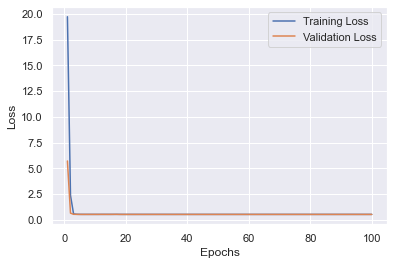

In [199]:
EPOCH = 100
train_res_recon_error = []
val_res_recon_error = []

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)


VQ_VAE.train()

for epoch in tqdm(range(EPOCH)):
    running_loss = 0.0
    count = 0
    quantized_merge = torch.empty(0, 1, 64).to(DEVICE)

    # Training loop
    for labels, inputs in enumerate(train_dataloader, 0):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        vq_loss, data_recon, perplexity, _, quantized = VQ_VAE(inputs)
        recon_error = F.mse_loss(data_recon, inputs) / data_variance
        loss = recon_error + vq_loss
        loss.backward()
        optimizer.step()
        count += 1
        running_loss += loss.item()
    
    # Calculate and store training loss for this epoch
    train_loss = running_loss / count
    train_res_recon_error.append(train_loss)
    
    # Validation loop (if you have a validation dataset)
    with torch.no_grad():
        running_val_loss = 0.0
        count = 0
        for labels, inputs in enumerate(test_dataloader, 0):
            inputs = inputs.to(DEVICE)
            vq_loss, data_recon, perplexity, _, quantized = VQ_VAE(inputs)
            recon_error = F.mse_loss(data_recon, inputs) / data_variance
            loss = recon_error + vq_loss
            count += 1
            running_val_loss += loss.item()
        
        # Calculate and store validation loss for this epoch
        val_loss = running_val_loss / count
        val_res_recon_error.append(val_loss)
    
    scheduler.step(val_loss)
    # Print and/or plot training and validation loss
    print(f"Epoch {epoch + 1}/{EPOCH}, Training Loss: {train_loss}, Validation Loss: {val_loss}, Learning Rate: {optimizer.param_groups[0]['lr']}")
    
# Plot training and validation loss curves
epochs = np.arange(1, EPOCH + 1)
plt.plot(epochs, train_res_recon_error, label='Training Loss')
plt.plot(epochs, val_res_recon_error, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [200]:
# Convert clinical_info and filenames to Series for easy filtering
clinical_info_series = pd.Series(clinical_info)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
clinical_mask = clinical_info_series == "Genetic PD"
filenames_mask = filenames_series.str.contains("BL")

# Combine the masks using logical AND
combined_mask = clinical_mask & filenames_mask

# Apply the combined mask to your dataset
filtered_dat = dat[combined_mask]
filtered_clinical_info = ["Genetic PD"]*sum(combined_mask)

# Check the shape of the filtered dataset
print(filtered_dat.shape)

(159, 1, 23989)


In [201]:
en_lat = []
en_quantized = []
en_reconstruction = []
data_set = Mydatasets(data1 = filtered_dat) # to check filtered data only

data_set = torch.utils.data.DataLoader(data_set, batch_size = 256, shuffle=False) 

#for i in range(len(dat)):
for i in range(len(filtered_dat)):
    en_data = data_set.dataset[i][0]
    latent_1 = VQ_VAE._encoder(en_data.view(1, 1, feature_num).float().to(DEVICE))
    _, data_recon, _, _,latent_2 = VQ_VAE(en_data.view(1, 1, feature_num).float().to(DEVICE))
    en_lat.append(latent_1.cpu().detach().numpy())
    en_quantized.append(latent_2.cpu().detach().numpy())
    en_reconstruction.append(data_recon.cpu().detach().numpy())

encode_out = np.array(en_lat)
encode_out = encode_out.reshape(len(filtered_dat), -1)
quantized_out = np.array(en_quantized)
quantized_out = quantized_out.reshape(len(filtered_dat), -1)
reconstruction_out = np.array(en_quantized)
reconstruction_out = reconstruction_out.reshape(len(filtered_dat), -1)

print('encode_out:', encode_out.shape)
print('quantized_out:', quantized_out.shape)

encode_out: (159, 512)
quantized_out: (159, 64)


# let's check if the encoding makes sense

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


TSNE_out: (159, 2)


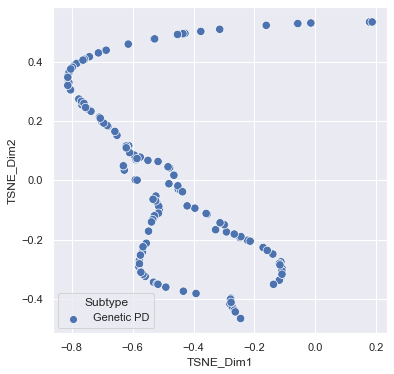

In [208]:
latent_Z = encode_out # original approach
#latent_Z = quantized_out # just to see

tsne = TSNE(#early_exaggeration=5,
              learning_rate=5, 
              perplexity=100, 
              min_grad_norm=1e-7, 
              n_iter=50000,
              n_components=2).fit_transform(latent_Z)
x_min, x_max = np.min(tsne, 0), np.max(tsne, 0)
tsne = tsne / (x_max - x_min)
print('TSNE_out:', tsne.shape)

True_labels = pd.DataFrame(filtered_clinical_info)

TSNE_result = pd.DataFrame(tsne, columns=['TSNE_Dim1', 'TSNE_Dim2'])
TSNE_result['Subtype'] = True_labels
#tsne of learened feature
plt.figure(figsize=(6,6))
sns.set(style='darkgrid',context='notebook')
sns.scatterplot(data = TSNE_result, x='TSNE_Dim1', y='TSNE_Dim2',hue='Subtype',s = 70)

plt.show()

[0.6506972  0.15837689]
[21.441183   5.2186913]
pca_result: (159, 2)


/var/folders/xr/0fvz4r2s4wx1hx13jlhxj2z00000gn/T/ipykernel_47375/4128091213.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  a = plt.scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap,c=colors,s=20)
/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


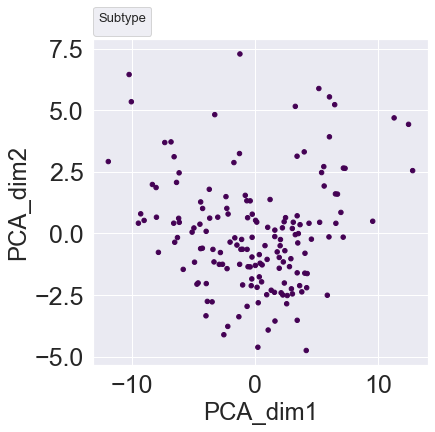

In [188]:
#PCA of learened feature
pca = PCA(n_components=2)
pca.fit(latent_Z)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)
pca_result = pca.transform(latent_Z)
print('pca_result:',pca_result.shape)

sns.set(style='darkgrid',context='notebook')
plt.figure(figsize=(6,6)) 

my_cmap = plt.get_cmap('viridis', len(TSNE_result['Subtype'].unique()))
# Map string labels to numeric values
subtype_labels = TSNE_result['Subtype'].unique()
subtype_to_numeric = {subtype: i for i, subtype in enumerate(subtype_labels)}
colors = [my_cmap(subtype_to_numeric[subtype]) for subtype in TSNE_result['Subtype']]

a = plt.scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap,c=colors,s=20)

L = plt.legend(*a.legend_elements(),
           borderaxespad = 1,
           title_fontsize = 13,
           fontsize = 13,
           loc = (0,1.01),
           ncol = 5,
           title="Subtype")

plt.xlabel("PCA_dim1", size=24)  
plt.ylabel("PCA_dim2", size=24)
plt.tick_params(axis='x', which='both', labelsize=25)
plt.tick_params(axis='y', which='both', labelsize=25)

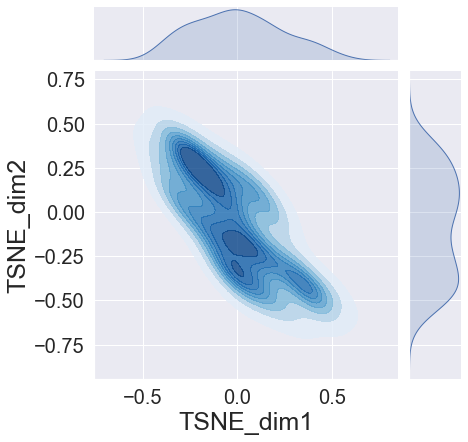

In [175]:
f = sns.jointplot(x=TSNE_result.TSNE_Dim1, y=TSNE_result.TSNE_Dim2, cmap="Blues", fill=True, kind='kde',height=6,
                 marginal_kws={"alpha":.2},thresh=0.05, alpha=.8)
f.ax_joint.set_xlabel("TSNE_dim1",fontsize=25)
f.ax_joint.set_ylabel("TSNE_dim2",fontsize=25)
f.ax_joint.tick_params(labelsize=20)

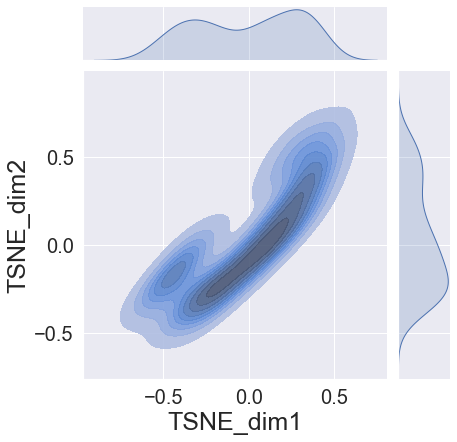

In [138]:
f = sns.jointplot(x=TSNE_result.TSNE_Dim1, y=TSNE_result.TSNE_Dim2, fill=True, kind='kde',hue=TSNE_result.Subtype,height=6,marginal_kws={"alpha":.2},thresh=0.05, alpha=.9)

f.ax_joint.legend_._visible=False
f.ax_joint.set_xlabel("TSNE_dim1",fontsize=25)
f.ax_joint.set_ylabel("TSNE_dim2",fontsize=25)
f.ax_joint.tick_params(labelsize=20)

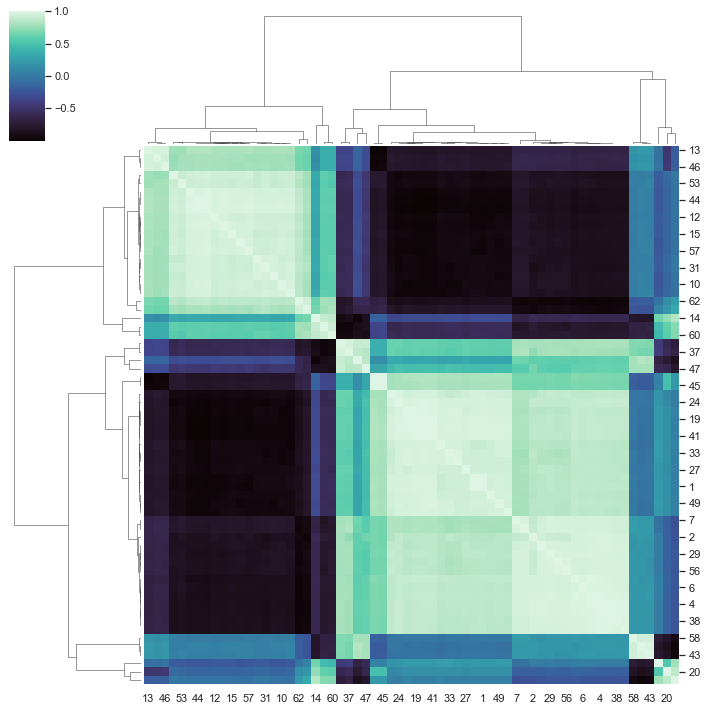

In [120]:
df = pd.DataFrame(quantized_out)
corr = df.corr(method = 'spearman')
sns.clustermap(pd.DataFrame(corr),cmap = 'mako')